In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import sleep
import pickle

In [57]:
def get_corners(nx, ny, img):
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), True)
    return([ret, corners])

In [58]:
cap = cv2.VideoCapture(0)

In [59]:
frames = []
sleep(5)
for c in range(200):
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray)
    # Display Frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break

In [60]:
cap.release()
cv2.destroyAllWindows()

In [61]:
def get_obj_points(x, y):
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] =  np.mgrid[0:x,0:y].T.reshape(-1,2)
    return objp

In [62]:
corners = [get_corners(7, 7, frame) for frame in frames[:100]]

In [74]:
corners = [corner[1] for corner in corners if corner[0]]

In [75]:
print(corners, len(corners))

[array([[[821.     , 342.     ]],

       [[829.48737, 392.61798]],

       [[836.0576 , 442.4786 ]],

       [[845.     , 497.     ]],

       [[857.5465 , 549.5281 ]],

       [[868.944  , 607.45337]],

       [[881.5    , 670.     ]],

       [[771.     , 340.     ]],

       [[778.5    , 391.     ]],

       [[784.5    , 445.     ]],

       [[790.9553 , 500.24118]],

       [[801.5    , 553.5    ]],

       [[810.5    , 613.5    ]],

       [[820.5    , 674.5    ]],

       [[717.5    , 344.5    ]],

       [[724.     , 395.     ]],

       [[730.5    , 448.5    ]],

       [[736.5    , 504.     ]],

       [[746.     , 559.     ]],

       [[753.     , 619.     ]],

       [[761.     , 682.     ]],

       [[661.33563, 349.09088]],

       [[668.5    , 402.     ]],

       [[674.     , 454.5    ]],

       [[680.     , 508.     ]],

       [[686.5    , 565.5    ]],

       [[693.5    , 626.     ]],

       [[699.5    , 688.     ]],

       [[608.     , 357.5    ]],

       [[613.

In [83]:
pickle.dump(corners, open("mac_corners.pkl", "wb"))

In [77]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

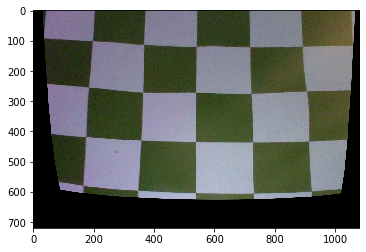

In [78]:
img = cv2.imread('/Users/bekkblando/Documents/github/computer_vision/assignment6/dist_test.jpg')
plt.imshow(cal_undistort(img, [get_obj_points(7, 7) for i in range(len(corners))], corners))

In [79]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [81]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
corners = pickle.load(open("mac_corners.pkl", "rb"))

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([get_obj_points(7, 7) for i in range(len(corners))], corners, img.shape[1:], None, None)

cap = cv2.VideoCapture(0)
for c in range(200):
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.undistort(gray, mtx, dist, None, mtx)
    ret, corners = get_corners(7, 7, gray)
    if ret:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        frame = draw(frame , corners2, imgpts)
        frame = cv2.drawChessboardCorners(frame, (7, 7), corners2,ret)
    # Display Frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [82]:
cap.release()
cv2.destroyAllWindows()

In [84]:
pickle.dump([ret, mtx, dist, rvecs, tvecs], open("cal_data.pkl", "wb"))